## Imports

In [1]:
import random
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, TimeDistributed, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2025-07-29 11:48:51.140878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753789731.348996      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753789731.413226      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


##  Config for tier-1 

In [3]:
N_MODALITIES = 3
N_DAYS = 10
IMG_SIZE = (64, 64)
DATA_DIR = "/kaggle/input/data-3k/data_set_3K"
MAX_SAMPLES_PER_CLASS = {'0':200, '1':200}

## Data Loading

In [4]:
def load_data(DATA_DIR, samples_per_class):
    X_raw, y = [], []
    for label, max_samples in samples_per_class.items():
        label_path = os.path.join(DATA_DIR, label)
        sample_folders = sorted(os.listdir(label_path))
        random.shuffle(sample_folders)  # Shuffle for randomness!
        count = 0

        for sample_id in sample_folders:
            if count >= max_samples:
                break
            sample_path = os.path.join(label_path, sample_id)
            modalities = sorted(os.listdir(sample_path))[:N_MODALITIES]
            cube = []

            for mod in modalities:
                mod_path = os.path.join(sample_path, mod)
                day_images = []
                for d in range(1, N_DAYS + 1):
                    img_path = os.path.join(mod_path, f"{str(d).zfill(2)}.png")
                    if os.path.exists(img_path):
                        img = Image.open(img_path).resize(IMG_SIZE).convert("L")
                        img_np = np.array(img)
                        day_images.append(img_np)
                if len(day_images) == N_DAYS:
                    cube.append(day_images)

            if len(cube) == N_MODALITIES:
                cube_np = np.transpose(np.array(cube), (1, 2, 3, 0))  # (DAYS, H, W, MODALITIES)
                X_raw.append(cube_np)
                y.append(int(label))
                count += 1

    return np.array(X_raw), np.array(y)

## Model Training

In [ ]:
def train_habnet(BASE_DIR, MAX_SAMPLES_PER_CLASS):
    # X_raw, y = load_data_habnet_only(BASE_DIR, MAX_SAMPLES_PER_CLASS)
    X_raw, y = load_data(BASE_DIR, MAX_SAMPLES_PER_CLASS)
    print(" Data shape:", X_raw.shape, y.shape)

    y_cat = to_categorical(y, num_classes=2)

    X_train, X_val, y_train, y_val = train_test_split(X_raw, y_cat, test_size=0.2, random_state=42, shuffle = True)

    input_shape = (X_raw.shape[1], X_raw.shape[2], X_raw.shape[3], X_raw.shape[4])
    print('input_shape : ', input_shape)
    inputs = Input(shape=input_shape)

    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Flatten())(x)  # Now shape: (batch, 10, features)
    
    # Sequence modeling with LSTM
    x = LSTM(128, return_sequences=False)(x)
    x = Dropout(0.4)(x)
    
    # Classification head
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

    print(" Starting Training...")
    start = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))
    end = time.time()
    print("\n Time taken:", round(end - start, 2), "seconds")
    
    X_test, y_test = load_data('/kaggle/input/test-hab-200/Test_HAB_200', {'0':200, '1':200})

    print(" Data shape:", X_test.shape, y_test.shape)

    
    print("\n Evaluation on Test Set:")
    loss, acc, rec, prec = model.evaluate(X_test, to_categorical(y_test))
    print("Test Accuracy:", acc)

    pred = model.predict(X_test).argmax(axis=1)
    print('Pred Shape : ', pred.shape)
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("HABNet Confusion Matrix")
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("HABNet Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

 Data shape: (400, 10, 64, 64, 3) (400,)
input_shape :  (10, 64, 64, 3)


I0000 00:00:1753789862.346235      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753789862.346952      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


 Starting Training...
Epoch 1/30


I0000 00:00:1753789875.494190      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - accuracy: 0.5169 - loss: 0.8074 - precision: 0.5169 - recall: 0.5169 - val_accuracy: 0.5125 - val_loss: 0.6883 - val_precision: 0.5125 - val_recall: 0.5125
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.6066 - loss: 0.6981 - precision: 0.6066 - recall: 0.6066 - val_accuracy: 0.6375 - val_loss: 0.6158 - val_precision: 0.6375 - val_recall: 0.6375
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6803 - loss: 0.6108 - precision: 0.6803 - recall: 0.6803 - val_accuracy: 0.6500 - val_loss: 0.5990 - val_precision: 0.6500 - val_recall: 0.6500
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6360 - loss: 0.6138 - precision: 0.6360 - recall: 0.6360 - val_accuracy: 0.6500 - val_loss: 0.6411 - val_precision: 0.6500 - val_recall: 0.6500
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6777 - loss: 0.5979 - precision: 0.6777 - recall: 0.6777 - val_accuracy: 0.5750 - val_loss: 0.7350 - val_pre

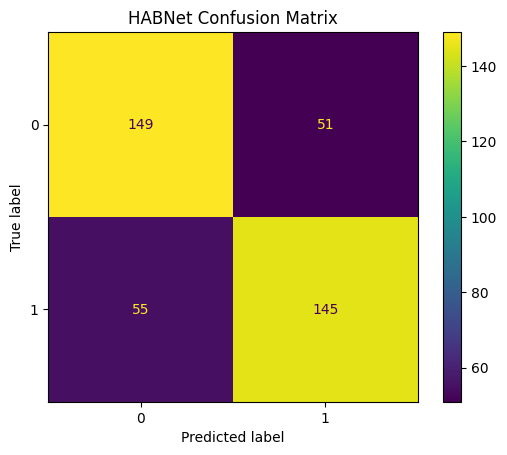

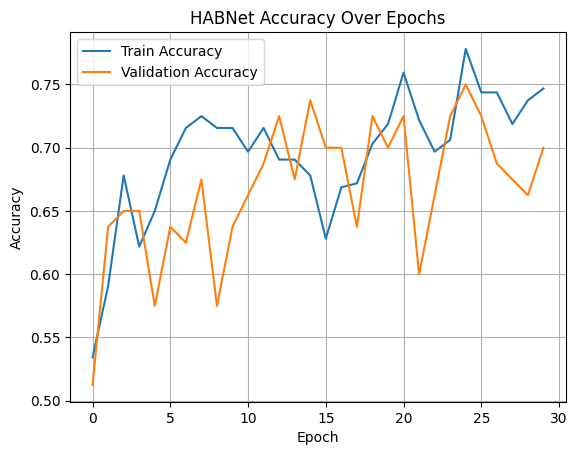

In [8]:
model = train_habnet(DATA_DIR, MAX_SAMPLES_PER_CLASS)

## Testing on unseen data

In [9]:
test_X, test_y = load_data('/kaggle/input/test-hab-200/Test_HAB_200', {'0':200, '1':200})

In [10]:
p = np.random.permutation(len(test_X))
X_test_shuffled = test_X[p]
y_test_shuffled = test_y[p]

In [11]:
test_X.shape, test_y.shape, X_test_shuffled.shape, y_test_shuffled.shape

((400, 10, 64, 64, 3), (400,), (400, 10, 64, 64, 3), (400,))

In [12]:
preds = model.predict(X_test_shuffled)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


              precision    recall  f1-score   support

           0       0.73      0.74      0.74       200
           1       0.74      0.72      0.73       200

    accuracy                           0.73       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.74      0.73      0.73       400



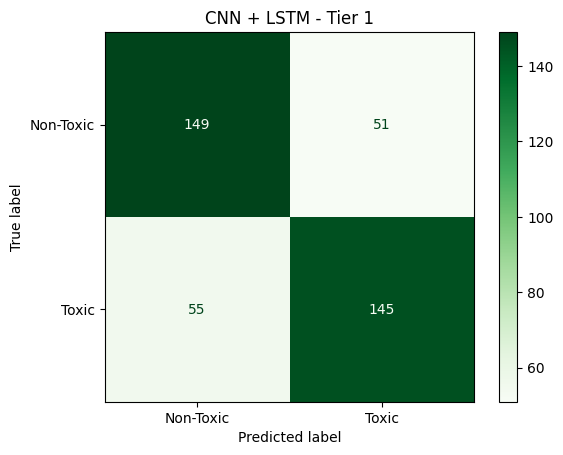

In [ ]:
print(classification_report(y_test_shuffled, preds)
ConfusionMatrixDisplay.from_predictions(y_test_shuffled, preds, display_labels=["Non-Toxic", "Toxic"], cmap="Greens")
plt.title("CNN + LSTM - Tier 1")
plt.show()

## Testing with single datacube

In [ ]:
def load_datacube(sample_path):
    modalities = sorted(os.listdir(sample_path))[:N_MODALITIES]
    cube = []

    for mod in modalities:
        mod_path = os.path.join(sample_path, mod)
        day_images = []
        for d in range(1, N_DAYS + 1):
            img_path = os.path.join(mod_path, f"{str(d).zfill(2)}.png")
            if os.path.exists(img_path):
                img = Image.open(img_path).resize(IMG_SIZE).convert("L")
                img_np = np.array(img)
                day_images.append(img_np)
        if len(day_images) == N_DAYS:
            cube.append(day_images)

    if len(cube) == N_MODALITIES:
        cube_np = np.transpose(np.array(cube), (1, 2, 3, 0))  # (DAYS, H, W, MODALITIES)
        x = cube_np
    return x

In [18]:
def predict_datacube(folder_path, model):
    x = load_datacube(folder_path)
    print(model.predict(np.expand_dims(x,0)))

In [19]:
predict_datacube('/kaggle/input/test-hab-200/Test_HAB_200/0/habnet_datacube_20160404_26.7614_-82.0611_0', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[0.9199049  0.08009516]]


In [20]:
predict_datacube('/kaggle/input/test-hab-200/Test_HAB_200/1/habnet_datacube_20161004_27.3316_-82.5779_408000', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.44461727 0.5553828 ]]


## Model Summary

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 64, 64, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 64, 64, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 32, 32, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 16384)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     8,454,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,448,072 (97.08 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 16,965,254 (64.72 MB)

## Saving Model

In [22]:
model.save('Teir-1_model.h5')